In [39]:
import pandas as pd
import vectorbtpro as vbt
import numpy as np


In [40]:
vbt.settings.plotting["layout"]["template"] = "vbt_dark"
vbt.settings.plotting["layout"]["width"] = 1200
vbt.settings.plotting['layout']['height'] = 200
vbt.settings.wrapping["freq"] = "1m"
# vbt.settings.portfolio['size_granularity'] = 0.001
vbt.settings.portfolio['init_cash'] = 10000

In [41]:
data_path = '/Users/ericervin/Documents/Coding/data-repository/data/BTCUSDT_1m_futures.pkl' 

futures_1m = vbt.BinanceData.load(data_path)

# Dollar Bar Functions

In [42]:


def dollar_bar_func(ohlc_df, dollar_bar_size):
    # Calculate dollar value traded for each row
    ohlc_df['DollarValue'] = ohlc_df['Close'] * ohlc_df['Volume']
    
    # Calculate cumulative dollar value
    ohlc_df['CumulativeDollarValue'] = ohlc_df['DollarValue'].cumsum()
    
    # Determine the number of dollar bars
    num_bars = int(ohlc_df['CumulativeDollarValue'].iloc[-1] / dollar_bar_size)
    
    # Generate index positions for dollar bars
    bar_indices = [0]
    cumulative_value = 0
    for i in range(1, len(ohlc_df)):
        cumulative_value += ohlc_df['DollarValue'].iloc[i]
        if cumulative_value >= dollar_bar_size:
            bar_indices.append(i)
            cumulative_value = 0
    
    # Create a new dataframe with dollar bars
    dollar_bars = []
    for i in range(len(bar_indices) - 1):
        start_idx = bar_indices[i]
        end_idx = bar_indices[i + 1]
        
        dollar_bar = {
            'Open': ohlc_df['Open'].iloc[start_idx],
            'High': ohlc_df['High'].iloc[start_idx:end_idx].max(),
            'Low': ohlc_df['Low'].iloc[start_idx:end_idx].min(),
            'Close': ohlc_df['Close'].iloc[end_idx],
            'Volume': ohlc_df['Volume'].iloc[start_idx:end_idx].sum(),
            'Quote volume': ohlc_df['Quote volume'].iloc[start_idx:end_idx].sum(),
            'Trade count': ohlc_df['Trade count'].iloc[start_idx:end_idx].sum(),
            'Taker base volume': ohlc_df['Taker base volume'].iloc[start_idx:end_idx].sum(),
            'Taker quote volume': ohlc_df['Taker quote volume'].iloc[start_idx:end_idx].sum()
        }
        
        if isinstance(ohlc_df.index, pd.DatetimeIndex):
            dollar_bar['Open Time'] = ohlc_df.index[start_idx]
            dollar_bar['Close Time'] = ohlc_df.index[end_idx] - pd.Timedelta(milliseconds=1)
        elif 'Open Time' in ohlc_df.columns:
            dollar_bar['Open Time'] = ohlc_df['Open Time'].iloc[start_idx]
            dollar_bar['Close Time'] = ohlc_df['Open Time'].iloc[end_idx] - pd.Timedelta(milliseconds=1)
        
        dollar_bars.append(dollar_bar)
    
    dollar_bars_df = pd.concat([pd.DataFrame([bar]) for bar in dollar_bars], ignore_index=True)
    
    return dollar_bars_df

# Create a simple function to simplify the number so we can use it in our column names
def simplify_number(num):
    """
    Simplifies a large number by converting it to a shorter representation with a suffix (K, M, B).
    simplify_number(1000) -> 1K
    """
    suffixes = ['', 'K', 'M', 'B']
    suffix_index = 0

    while abs(num) >= 1000 and suffix_index < len(suffixes) - 1:
        num /= 1000.0
        suffix_index += 1

    suffix = suffixes[suffix_index] if suffix_index > 0 else ''
    simplified_num = f'{int(num)}{suffix}'

    return simplified_num

def merge_and_fill_dollar_bars(original_df, dollar_bars_df, dollar_bar_size):
    # Add prefix to column names in dollar bars dataframe
    dollar_bar_prefix = f'db_{simplify_number(dollar_bar_size)}_'
    dollar_bars_df_renamed = dollar_bars_df.add_prefix(dollar_bar_prefix)

    # Convert 'Open Time' columns to pandas datetime format and set them as index
    dollar_bars_df_renamed.index = pd.to_datetime(dollar_bars_df_renamed[dollar_bar_prefix + 'Open Time'])

    # Merge the dataframes on the index
    merged_df = original_df.merge(dollar_bars_df_renamed, how='left', left_index=True, right_index=True)

    # Set the flag for a new dollar bar with prefix
    merged_df[dollar_bar_prefix + 'NewDBFlag'] = ~merged_df[dollar_bar_prefix + 'Close'].isna()

    # Forward fill the NaN values for all columns except the new dollar bar flag
    columns_to_ffill = [col for col in merged_df.columns if col != dollar_bar_prefix + 'NewDBFlag']
    merged_df[columns_to_ffill] = merged_df[columns_to_ffill].fillna(method='ffill')

    # Fill the remaining NaN values in the new dollar bar flag column with False
    merged_df[dollar_bar_prefix + 'NewDBFlag'] = merged_df[dollar_bar_prefix + 'NewDBFlag'].fillna(False)
    
    # Assign the renamed 'Open Time' column back to the dataframe
    merged_df[dollar_bar_prefix + 'Open Time'] = merged_df[dollar_bar_prefix + 'Open Time']

    return merged_df





# Load Dollar Bars from pkl

In [43]:
# Rather than make new dollar bars just read in the pkl file
dollar_bar_size = 90_000_000
btc_90M_db_vbt = vbt.BinanceData.load('data/btc_90M_db_vbt.pkl')
btc_90M_copy = btc_90M_db_vbt.get().copy()
futures_1m_copy = futures_1m.get().copy()

In [44]:
data = btc_90M_db_vbt['2021-01-01':'2023-01-01']
outofsample_data = btc_90M_db_vbt['2023-01-01':'2023-06-03']
print(data.shape)
print(outofsample_data.shape)

(105949,)
(19012,)


## Read in the Predictions from the Model
Read in the predictions and attach them to the dollar bar dataframe

In [45]:
from joblib import load, dump
insample_model = load('models/model_upto_2023.joblib')


In [46]:

n = 150 # number of periods in the future to predict

# Generate the features (X) using TA-Lib indicators
# X = data.run("talib", periods=vbt.run_func_dict(mavp=n))
X = data.get().copy()
# psar_vbt = data.run("pandas_ta:PSAR", append=True, acceleration=0.02, maximum=0.2)
# add trend label as a feature
X['trend'] = data.run("trendlb", .2, 0.05, mode="binary").labels # add trend label as a feature
# X['psar_cross'] = psar_vbt.psarr

# Add time features
X['dayofmonth'] = X.index.day
X['month'] = X.index.month
X['year'] = X.index.year
X['hour'] = X.index.hour
X['minute'] = X.index.minute
X['dayofweek'] = X.index.dayofweek
X['dayofyear'] = X.index.dayofyear

# Now we are trying to generate future price predictions so we will set the y labels to the price change n periods in the future
y = (data.close.shift(-n) / data.close - 1).rolling(n).mean() # future price change we use rolling mean to smooth the data

# Preprocessing steps to handle NaNs
X = X.replace([-np.inf, np.inf], np.nan) # replace inf with nan
invalid_column_mask = X.isnull().all(axis=0) | (X.nunique() == 1) # drop columns that are all nan or have only one unique value
X = X.loc[:, ~invalid_column_mask] # drop invalid columns
invalid_row_mask = X.isnull().any(axis=1) | y.isnull() # drop rows that have nan in any column or in y

# Drop invalid rows in X and y
X = X.loc[~invalid_row_mask]
y = y.loc[~invalid_row_mask]

In [47]:
# Drop Open time and close time
X = X.drop(['Open Time','Close Time'], axis=1)

In [48]:
from sklearn.metrics import r2_score

In [49]:
filename = 'models/model_upto_2023.joblib'
# Load the model from the .joblib file
final_pipeline = load(filename) 

# Make predictions on the entire dataset
insample_predictions = final_pipeline.predict(X)

# Calculate the R-squared score on the entire dataset
r2 = r2_score(y, insample_predictions)

print(f"R-squared on the entire dataset: {r2}")

R-squared on the entire dataset: 0.7439928062964846


Add the predictions to this dollar bar dataframe before we merge it

In [50]:

n = 150 # number of periods in the future to predict

# Generate the features (X) using TA-Lib indicators
# X = data.run("talib", periods=vbt.run_func_dict(mavp=n))
Xoos = outofsample_data.get()
psar_vbt = outofsample_data.run("pandas_ta:PSAR", append=True, acceleration=0.02, maximum=0.2) # I didn't end up using this
# add trend label as a feature
Xoos['trend'] = outofsample_data.run("trendlb", .2, 0.05, mode="binary").labels # add trend label as a feature
# X['psar_cross'] = psar_vbt.psarr
# Drop the time columns
# Drop Open time and close time
Xoos = Xoos.drop(['Open Time','Close Time'], axis=1)
# Add time features
Xoos['dayofmonth']  = Xoos.index.day
Xoos['month']       = Xoos.index.month
Xoos['year']        = Xoos.index.year
Xoos['hour']        = Xoos.index.hour
Xoos['minute']      = Xoos.index.minute
Xoos['dayofweek']   = Xoos.index.dayofweek
Xoos['dayofyear']   = Xoos.index.dayofyear

# Now we are trying to generate future price predictions so we will set the y labels to the price change n periods in the future
yoos = (outofsample_data.close.shift(-n) / outofsample_data.close - 1).rolling(n).mean() # future price change we use rolling mean to smooth the data

# Preprocessing steps to handle NaNs
Xoos = Xoos.replace([-np.inf, np.inf], np.nan) # replace inf with nan
invalid_column_mask = Xoos.isnull().all(axis=0) #| (Xoos.nunique() == 1) # removed the second condition because `year` column is always the same for 2023
Xoos = Xoos.loc[:, ~invalid_column_mask] # drop invalid columns
invalid_row_mask = Xoos.isnull().any(axis=1) | yoos.isnull() # drop rows that have nan in any column or in y

# Drop invalid rows in X and y
Xoos = Xoos.loc[~invalid_row_mask]
yoos = yoos.loc[~invalid_row_mask]

/var/folders/dt/m1bsm13n187d7m0ssssp79ww0000gn/T/ipykernel_57721/1197841672.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xoos['trend'] = outofsample_data.run("trendlb", .2, 0.05, mode="binary").labels # add trend label as a feature


In [51]:
# Make predictions on the entire dataset
outofsample_predictions = final_pipeline.predict(Xoos)

# Calculate the R-squared score on the entire dataset
r2 = r2_score(yoos, outofsample_predictions)

print(f"R-squared on the out of sample dataset: {r2}")

R-squared on the out of sample dataset: -0.5081144832850475


In [52]:
# create a pandas dataframe or series with the predictions and the index from the out of sample data
outofsample_predictions = pd.Series(outofsample_predictions, index=yoos.index)
outofsample_predictions = outofsample_predictions.rename("outofsample_predictions")
print(outofsample_predictions.shape)

# create a pandas dataframe or series with the predictions and the index from the out of sample data
insample_predictions = pd.Series(insample_predictions, index=X.index)
insample_predictions = insample_predictions.rename("insample_predictions")
print(insample_predictions.shape)

(16809,)
(103513,)


Start                         2023-01-05 00:12:00+00:00
End                           2023-05-12 19:25:00+00:00
Period                                 11 days 16:09:00
Start Value                                     10000.0
Min Value                                   9941.088611
Max Value                                  15972.286364
End Value                                  15032.780814
Total Return [%]                              50.327808
Benchmark Return [%]                          53.705321
Total Time Exposure [%]                       35.962877
Max Gross Exposure [%]                       105.326711
Max Drawdown [%]                               7.475423
Max Drawdown Duration                   4 days 13:27:00
Total Orders                                        170
Total Fees Paid                                     0.0
Total Trades                                         85
Win Rate [%]                                  49.411765
Best Trade [%]                                13

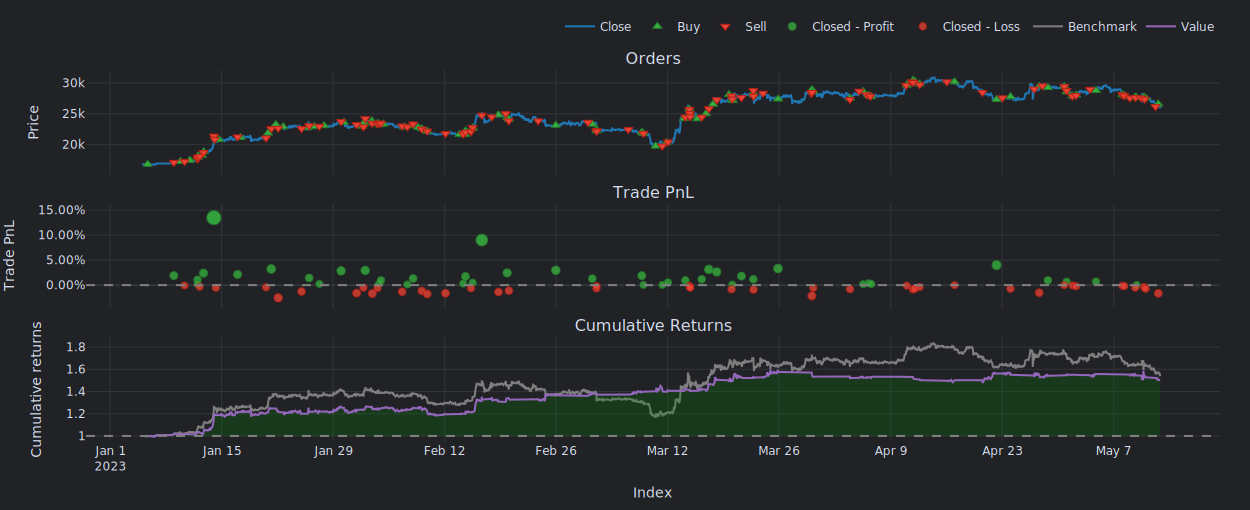

Total return: 0.5370532132988679
Max Drawdown: -0.22403841586039874


In [59]:
oos_pf = vbt.Portfolio.from_signals(
    outofsample_data.close[outofsample_predictions.index], # use only the test set
    entries         = outofsample_predictions > 0.05, # long when probability of price increase is greater than 2%
    exits           = outofsample_predictions < 0.00, # long when probability of price increase is greater than 2%
    short_entries   = outofsample_predictions < -0.04, # long when probability of price increase is greater than 2%
    short_exits     = outofsample_predictions > 0.0, # short when probability prediction is less than -5%
    # direction="both" # long and short
)
print(oos_pf.stats())
oos_pf.plot().show_svg()
# For comparison run a buy and hold strategy
buy_and_hold = vbt.Portfolio.from_holding(outofsample_data.close[outofsample_predictions.index])
print(f'Total return: {buy_and_hold.total_return}')
print(f'Max Drawdown: {buy_and_hold.max_drawdown}')


In [54]:
insample_pf = vbt.Portfolio.from_signals(
    data.close[insample_predictions.index],  # use only the test set
    entries         = insample_predictions > 0.05,  # long when probability of price increase is greater than 2%
    exits           = insample_predictions < 0.00,  # long when probability of price increase is greater than 2%
    short_entries   = insample_predictions < -0.04,  # long when probability of price increase is greater than 2%
    short_exits     = insample_predictions > 0.0,  # short when probability prediction is less than -5%
    # direction="both" # long and short
)
print(insample_pf.stats())

Start                         2021-01-02 16:21:00+00:00
End                           2022-11-21 21:46:00+00:00
Period                                 71 days 21:13:00
Start Value                                     10000.0
Min Value                                   9484.563365
Max Value                              429140834.878255
End Value                              424887167.635672
Total Return [%]                         4248771.676357
Benchmark Return [%]                         -51.904439
Total Time Exposure [%]                       30.071585
Max Gross Exposure [%]                       107.936016
Max Drawdown [%]                              13.074224
Max Drawdown Duration                   3 days 23:11:00
Total Orders                                        362
Total Fees Paid                                     0.0
Total Trades                                        181
Win Rate [%]                                  85.082873
Best Trade [%]                                30

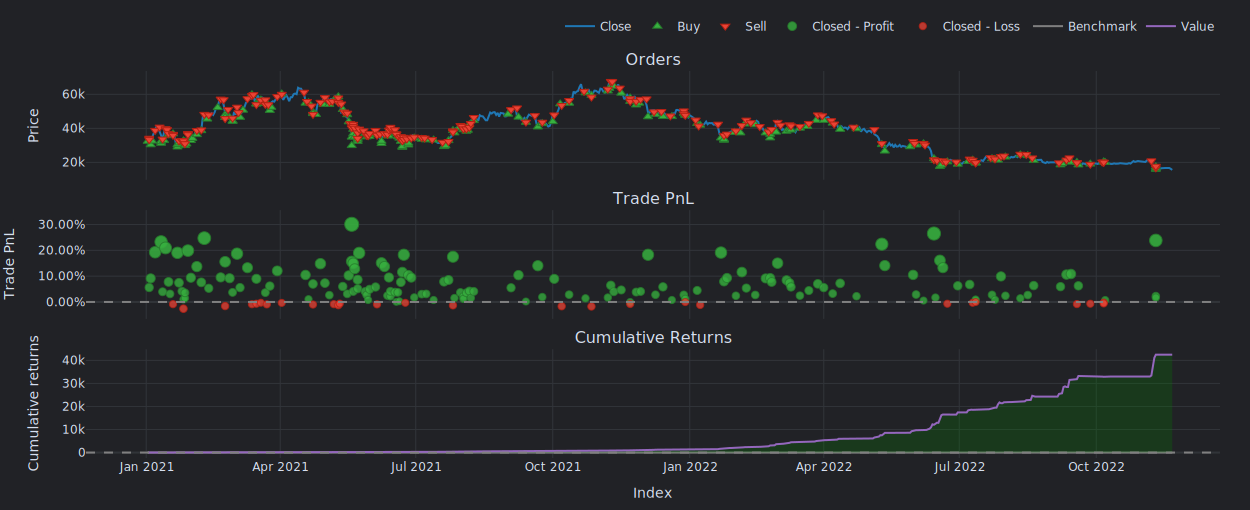

In [56]:
insample_pf.resample('1d').plot().show_svg()

In [31]:
# Create a new dataframe with the dollar bars merged into the original dataframe
full_df = merge_and_fill_dollar_bars(futures_1m_copy, btc_90M_copy, dollar_bar_size)

In [32]:
full_df

,Open,High,Low,Close,Volume,Quote volume,Trade count,Taker base volume,Taker quote volume,db_90M_Open,...,db_90M_Low,db_90M_Close,db_90M_Volume,db_90M_Quote volume,db_90M_Trade count,db_90M_Taker base volume,db_90M_Taker quote volume,db_90M_Open Time,db_90M_Close Time,db_90M_NewDBFlag
Open time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,28948.19,28997.16,28935.30,28991.01,143.661,4.161510e+06,1120,114.439,3.315299e+06,28948.19,...,28706.0,28796.3,3181.960,9.183460e+07,24166.0,1277.389,3.689901e+07,2021-01-01 00:00:00+00:00,2021-01-01 00:14:59.999000+00:00,True
2021-01-01 00:01:00+00:00,28992.98,29045.93,28991.01,29035.18,256.280,7.437731e+06,1967,179.650,5.213713e+06,28948.19,...,28706.0,28796.3,3181.960,9.183460e+07,24166.0,1277.389,3.689901e+07,2021-01-01 00:00:00+00:00,2021-01-01 00:14:59.999000+00:00,False
2021-01-01 00:02:00+00:00,29036.41,29036.97,28993.19,29016.23,102.675,2.979644e+06,987,44.060,1.278719e+06,28948.19,...,28706.0,28796.3,3181.960,9.183460e+07,24166.0,1277.389,3.689901e+07,2021-01-01 00:00:00+00:00,2021-01-01 00:14:59.999000+00:00,False
2021-01-01 00:03:00+00:00,29016.23,29023.87,28995.50,29002.92,85.762,2.487845e+06,832,56.768,1.646753e+06,28948.19,...,28706.0,28796.3,3181.960,9.183460e+07,24166.0,1277.389,3.689901e+07,2021-01-01 00:00:00+00:00,2021-01-01 00:14:59.999000+00:00,False
2021-01-01 00:04:00+00:00,29005.93,29019.98,29000.00,29000.00,70.246,2.037999e+06,752,46.645,1.353346e+06,28948.19,...,28706.0,28796.3,3181.960,9.183460e+07,24166.0,1277.389,3.689901e+07,2021-01-01 00:00:00+00:00,2021-01-01 00:14:59.999000+00:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-03 23:08:00+00:00,27055.50,27058.10,27055.50,27058.10,33.934,9.181214e+05,538,10.977,2.970001e+05,27036.20,...,27010.0,27050.8,3446.435,9.321961e+07,35797.0,1852.779,5.012026e+07,2023-06-03 22:22:00+00:00,2023-06-03 22:55:59.999000+00:00,False
2023-06-03 23:09:00+00:00,27058.10,27060.00,27058.00,27060.00,22.295,6.032967e+05,375,18.930,5.122406e+05,27036.20,...,27010.0,27050.8,3446.435,9.321961e+07,35797.0,1852.779,5.012026e+07,2023-06-03 22:22:00+00:00,2023-06-03 22:55:59.999000+00:00,False
2023-06-03 23:10:00+00:00,27060.00,27060.50,27059.90,27060.50,40.601,1.098664e+06,494,24.383,6.598049e+05,27036.20,...,27010.0,27050.8,3446.435,9.321961e+07,35797.0,1852.779,5.012026e+07,2023-06-03 22:22:00+00:00,2023-06-03 22:55:59.999000+00:00,False
